#### Transfer Learning Modell 4
- Backbone VGG-16
- Images cropped and resized
- VGG 16 Paper preprocessing as done in Paper for Network: https://arxiv.org/abs/1409.1556
- lessen overfitting by adding dropout layer
- use Reduce:LROnPlateau and Model Checkpoint
- fine tuning: partially unfrozen and retrained on new data

Sources for use and issue resolving:
https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import backend as K

In [3]:
import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model

In [4]:
import tensorflow as tf

In [6]:
df = pd.read_csv('/content/drive/MyDrive/train4_small.csv')

In [7]:
df.head()

,filename,labels
0,3f58d128caf6.jpg,glaucoma
1,802b4bfabd52.jpg,md
2,7bcfab1fa2da.jpg,opacity
3,012e91949ec4.jpg,opacity
4,6386346fb595.jpg,opacity


In [8]:
df.labels.value_counts()

normal      500
glaucoma    500
md          500
opacity     500
Name: labels, dtype: int64

In [9]:
# Original Images
in_dir = '/content/drive/MyDrive/four'

### Image Generator

In [10]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split = 0.25)

In [11]:
train_gen = datagen.flow_from_dataframe(dataframe = df, 
                                        directory = in_dir, 
                                        x_col = "filename", 
                                        y_col = 'labels',
                                        batch_size = 32, 
                                        seed = 2, 
                                        shuffle = True, 
                                        class_mode = "categorical", 
                                        classes = ['opacity', 'glaucoma','md', 'normal'],
                                        subset='training',
                                        target_size = (224,224))

Found 1500 validated image filenames belonging to 4 classes.


In [12]:
val_gen = datagen.flow_from_dataframe(dataframe = df, 
                                      directory = in_dir,
                                      x_col = "filename", 
                                      y_col = 'labels',
                                      batch_size = 32, 
                                      seed = 2, 
                                      shuffle = False,#Labels nicht shuffeln für CM 
                                      class_mode = "categorical", 
                                      classes = ['opacity', 'glaucoma','md', 'normal'],
                                      subset='validation',
                                      target_size = (224,224))

Found 500 validated image filenames belonging to 4 classes.


In [13]:
imgs, labels = next(train_gen)

In [14]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


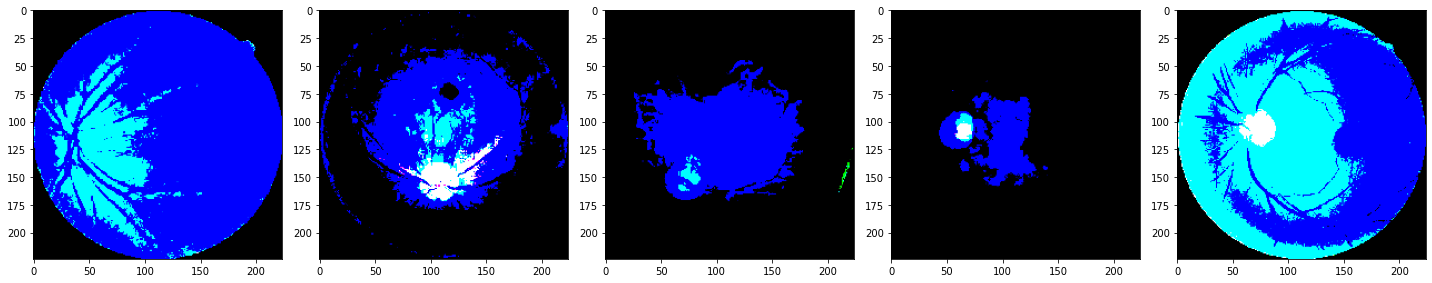

In [16]:
plotImages(imgs)

### Model

In [17]:
base = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [18]:
base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
# freezing of all blocks but last one
for layer in base.layers[:15]:
    layer.trainable = False

In [20]:
for i, layer in enumerate(base.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [23]:
# define new head
x = base.output
x = Flatten(name='flatten')(x) 
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) 
x = Dense(4, activation='softmax')(x) 
model = Model(inputs=base.input, outputs=x)

In [24]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
checkpoint = ModelCheckpoint('vgg16_finetune.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [25]:
step_size_train = train_gen.n//train_gen.batch_size
step_size_val = val_gen.n//val_gen.batch_size

In [26]:
model.compile(optimizer=Adam(learning_rate=5e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
history = model.fit(x=train_gen, validation_data=val_gen, steps_per_epoch=step_size_train, 
          validation_steps=step_size_val, epochs=50, callbacks=[lr_reduce,checkpoint], verbose=2)

Epoch 1/50
46/46 - 13s - loss: 0.0166 - accuracy: 0.9946 - val_loss: 2.0093 - val_accuracy: 0.5958

Epoch 00001: val_accuracy did not improve from 0.68542
Epoch 2/50
46/46 - 13s - loss: 0.0436 - accuracy: 0.9830 - val_loss: 1.3004 - val_accuracy: 0.6083

Epoch 00002: val_accuracy did not improve from 0.68542
Epoch 3/50
46/46 - 13s - loss: 0.0272 - accuracy: 0.9911 - val_loss: 1.1266 - val_accuracy: 0.6917

Epoch 00003: val_accuracy improved from 0.68542 to 0.69167, saving model to vgg16_finetune.h15
INFO:tensorflow:Assets written to: vgg16_finetune.h15/assets
Epoch 4/50
46/46 - 12s - loss: 0.0192 - accuracy: 0.9966 - val_loss: 1.6895 - val_accuracy: 0.6271

Epoch 00004: val_accuracy did not improve from 0.69167
Epoch 5/50
46/46 - 12s - loss: 0.0110 - accuracy: 0.9966 - val_loss: 1.4860 - val_accuracy: 0.6729

Epoch 00005: val_accuracy did not improve from 0.69167
Epoch 6/50
46/46 - 13s - loss: 0.0114 - accuracy: 0.9959 - val_loss: 1.8024 - val_accuracy: 0.6333

Epoch 00006: val_accurac

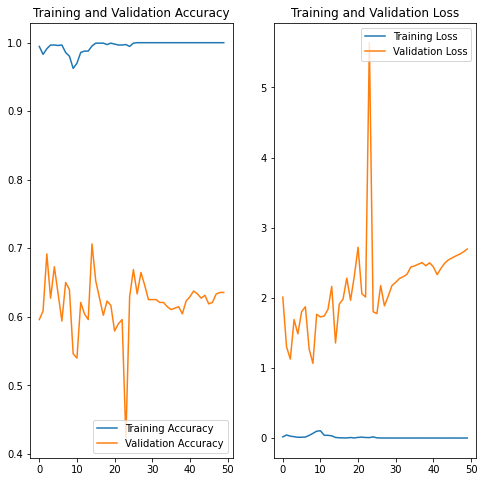

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

 ok. still kind of a lot of overfitting. 
 - More dropout. 
 - More images/more augmentation. 
 - Weight decay. 
 